In [20]:
import pandas as pd
import chardet
import os
def read_files_in_folder(folder_path):
    coding_s = {}
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'rb') as f:
                encoding = chardet.detect(f.read())['encoding']
                coding_s.setdefault(encoding, 0)
                coding_s[encoding] += 1
    return coding_s

# 示例使用
folder_path = "长春市"
'''
folder_path最好用相对路径，增加代码的可移植性
'''
s = read_files_in_folder(folder_path)
df=pd.DataFrame(list(s.items()), columns=['encoding', 'count'], index=None)
print(df.sort_values(by='count', ascending=True).to_string(index=False))
# ascending=True时根据编码方式的出现次数升序输出

 encoding  count
UTF-8-SIG     15


In [21]:
import pandas as pd
import os
import chardet

folder_path= "长春市"

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

def read_csv_with_encoding(file_path):
    encoding = detect_encoding(file_path)
    return pd.read_csv(file_path, encoding=encoding)
def GetDataFrame(folder_path):
    data_frames=[]
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            df = read_csv_with_encoding(file_path)
            data_frames.append(df)
    return data_frames
data_frames = GetDataFrame(folder_path)
data = pd.concat(data_frames, ignore_index=True)
data.drop_duplicates(inplace=True)
data.ffill(inplace=True)  # 使用 ffill 方法填充缺失值
data.columns = data.columns.str.replace(r'\r', '', regex=True).str.strip()


In [17]:
# 创建一个新的列，将经纬度坐标四舍五入到小数点后两位（假设0.01度的栅格）
data['grid_x'] = data['lon_gcj02'].round(2)
data['grid_y'] = data['lat_gcj02'].round(2)
# 按网格统计每个格子中的设施数量
grid_density = data.groupby(['grid_x', 'grid_y']).size().reset_index(name='facility_count')

# 统计每个网格中的行业种类数量
industry_diversity = data.groupby(['grid_x', 'grid_y', 'type']).size().reset_index(name='type_count')
industry_diversity_count = industry_diversity.groupby(['grid_x', 'grid_y']).size().reset_index(name='industry_diversity')
print(industry_diversity_count)


      grid_x  grid_y  industry_diversity
0     110.54   41.28                   1
1     110.56   41.28                   2
2     110.58   41.24                   1
3     110.58   41.25                   1
4     110.58   41.30                   1
...      ...     ...                 ...
6414  112.29   40.28                   2
6415  112.30   40.24                   2
6416  112.30   40.25                   1
6417  112.30   40.27                   1
6418  112.31   40.26                   2

[6419 rows x 3 columns]


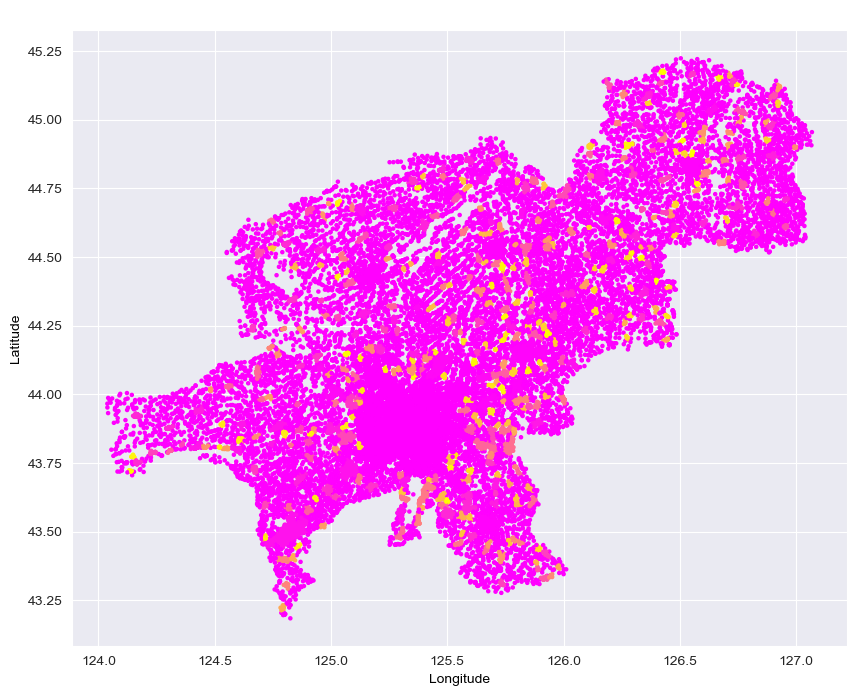

In [22]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import os

# 只使用经纬度进行聚类
name = folder_path
coordinates = data[['lon_gcj02', 'lat_gcj02']].values
db = DBSCAN(eps=0.01, min_samples=10).fit(coordinates)
data['cluster'] = db.labels_

# 可视化结果
plt.figure(figsize=(10, 8), facecolor='white')

plt.scatter(data['lon_gcj02'], data['lat_gcj02'], c=data['cluster'], cmap='spring', s=5)
plt.title("Spatial Clustering of Facilities", color='white')
plt.xlabel("Longitude", color='black')
plt.ylabel("Latitude", color='black')

# 如果想要保存图片的话
# plt.savefig('S1-3.jpg')
# 这里默认图片保存到项目的根目录里
# 或者建一个文件夹放图片
# 创建一个名为images的文件夹
# 已经存在也没有影响
os.makedirs('images', exist_ok=True)
# 保存图片到images文件夹
plt.savefig(f'images\\{name}-1.jpg')
plt.show()


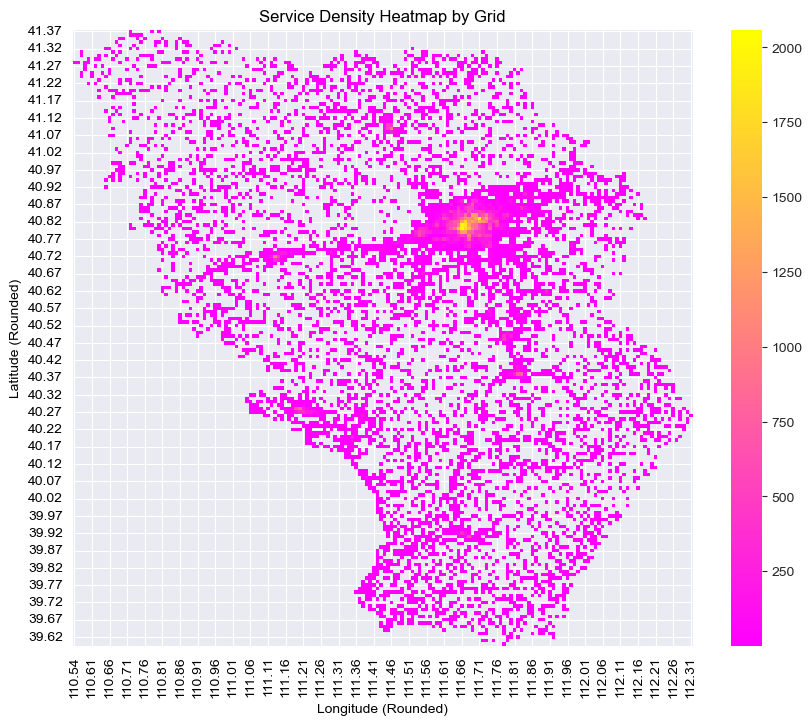

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 创建透视表并排序：`grid_y`按照从大到小排序，以便符合地理方向
grid_pivot = grid_density.pivot(index='grid_y', columns='grid_x', values='facility_count').sort_index(ascending=False)

# 绘制热力图
plt.figure(figsize=(10, 8), facecolor='white')
sns.heatmap(grid_pivot, cmap="spring", annot=False, cbar=True, annot_kws={"color": "white"})
plt.title("Service Density Heatmap by Grid", color='black')
plt.xlabel("Longitude (Rounded)", color='black')
plt.ylabel("Latitude (Rounded)", color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')

os.makedirs('images', exist_ok=True)
# 保存图片到images文件夹
plt.savefig(f'images\\{name}-2.jpg')

plt.show()
